<h2>Imports</h2>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tt
from torchvision.models import resnet50,ResNet50_Weights
from torchvision.datasets import ImageFolder

from torch.utils.data import random_split,DataLoader

import os

<h2>Data Loading and Transformations</h2>

In [2]:
data = r'../Data/chest_xray/chest_xray'

print(os.listdir(data))


['.DS_Store', 'test', 'train', 'val']


In [3]:
positive= os.listdir(data+ "/train/PNEUMONIA")
negative = os.listdir(data + "/train/NORMAL")

print(f"Positive Images : {len(positive)}\n Negative Images : {len(negative)}")

Positive Images : 3876
 Negative Images : 1342


C:\Users\dhaka\AppData\Local\Temp\ipykernel_18308\3967545190.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x,y=y,palette=["Orange","Blue"])


<Axes: >

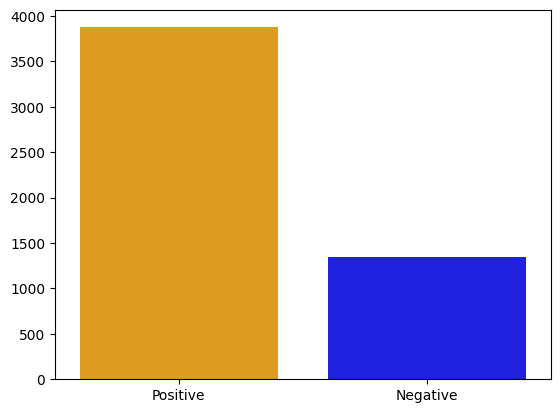

In [9]:
#Plot the imbalance
y=[len(positive),len(negative)]
x=["Positive","Negative"]
sns.barplot(x=x,y=y,palette=["Orange","Blue"])

In [7]:
#Define the transformations
transforms=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()

                                           ])

In [8]:
dataset = ImageFolder(data+'/train', transform=transforms)
dataset.classes

['NORMAL', 'PNEUMONIA']

<h2>Visualizations</h2>

Label:  NORMAL (0)


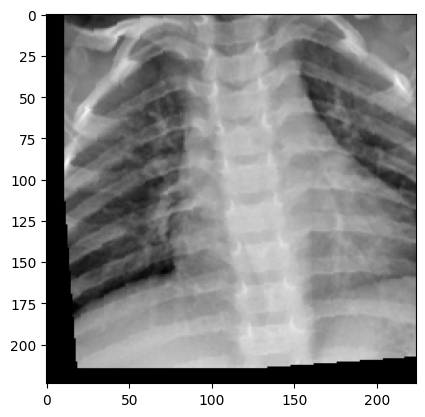

In [9]:


def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")

    # .permute() used because Pytorch stores image in (C,H,W)
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[4])

In [10]:
trainSize=round(0.71*len(dataset))
valSize=len(dataset)-trainSize
train, val = random_split(dataset, [trainSize, valSize])
len(train), len(val)

(3703, 1513)

In [11]:
batch_size=16

trainLoader = DataLoader(train, batch_size, shuffle=True, num_workers=2)
valLoader = DataLoader(val, batch_size*2, num_workers=2)

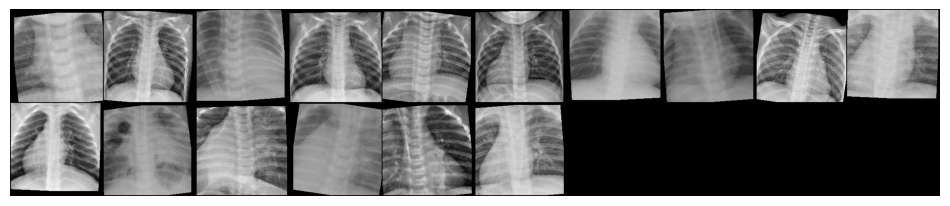

In [12]:
images, labels = next(iter(trainLoader))

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
plt.show()

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

<h2>Define the Resnet50 model</h2>

In [14]:
class PneumoniaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        #Load the PreTrained Resnet50
        self.model=resnet50(weights=ResNet50_Weights.DEFAULT)
        
        for params in self.model.parameters():
            #Freeze all parameters
            params.require_grad=False

        #Create a new fully connected layer with unfrozen params
        self.model.fc=nn.Linear(self.model.fc.in_features,2)

    def forward(self,x):
        return self.model(x)

<h2>Create Model Instance</h2>

In [15]:
classifier=PneumoniaClassifier().to(device)

In [18]:
epochs=10
lr=0.0001

optimizer=torch.optim.Adam(classifier.parameters(),lr=lr)


In [19]:

loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    classifier.train()
    running_loss = 0.0

    for batch in trainLoader:
        images, labels = batch[0].to(device), batch[1].to(device)

        y_pred = classifier(images)
        loss = loss_fn(y_pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"\nEpoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(trainLoader):.4f}")
    print(f"GPU Allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")

    classifier.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in valLoader:
            images, labels = batch[0].to(device), batch[1].to(device)
    
            outputs = classifier(images) 
            loss = loss_fn(outputs, labels)  
            val_loss += loss.item()
    
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)


    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(valLoader)}, Accuracy: {val_accuracy}%")


        

   
    


Epoch 1/10, Train Loss: 0.1800
GPU Allocated: 408.65 MB
Validation Loss: 0.10066373211642106, Accuracy: 96.49702577660278%

Epoch 2/10, Train Loss: 0.1042
GPU Allocated: 411.53 MB
Validation Loss: 0.08408956745794664, Accuracy: 97.6867151354924%

Epoch 3/10, Train Loss: 0.0689
GPU Allocated: 410.60 MB
Validation Loss: 0.06489382076930876, Accuracy: 98.14937210839392%

Epoch 4/10, Train Loss: 0.0667
GPU Allocated: 411.19 MB
Validation Loss: 0.08799713936120195, Accuracy: 96.89358889623266%

Epoch 5/10, Train Loss: 0.0637
GPU Allocated: 409.08 MB
Validation Loss: 0.08880573881712432, Accuracy: 96.76140118968937%

Epoch 6/10, Train Loss: 0.0408
GPU Allocated: 408.82 MB
Validation Loss: 0.04874275555387916, Accuracy: 98.5459352280238%

Epoch 7/10, Train Loss: 0.0391
GPU Allocated: 410.69 MB
Validation Loss: 0.06328772965935059, Accuracy: 97.95109054857899%

Epoch 8/10, Train Loss: 0.0344
GPU Allocated: 409.14 MB
Validation Loss: 0.06371259673323948, Accuracy: 98.21546596166557%

Epoch 9/1

<h2>Testing Part<h2>

In [28]:
positive= os.listdir(data+ "/test/PNEUMONIA")
negative = os.listdir(data + "/test/NORMAL")

print(f"Length of Test data:\n Positive: {len(positive)} \n Negative {len(negative)}")



Length of Test data:
 Positive: 195 
 Negative 200


In [29]:
testTransforms=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.ToTensor()
                                           ])

In [30]:
testDataset=ImageFolder(data+"/test",transform=testTransforms)

In [31]:
batch_size=16
testLoader=DataLoader(testDataset,batch_size,shuffle=True)

In [32]:
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for batch in testLoader:
        images, labels = batch[0].to(device), batch[1].to(device)

        outputs = classifier(images) 
        loss = loss_fn(outputs, labels)  
        test_loss += loss.item()

        values, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/len(testLoader)}, Accuracy: {test_accuracy}%")

Test Loss: 0.22983158738352358, Accuracy: 91.13924050632912%


In [37]:
#Save the model
torch.save(classifier.state_dict(), 'TrainedModel.pth')


<h2> Hence the best model with accuracy 91% is saved</h2>

In [39]:
print(torchvision.__version__)
print(torch.__version__)

0.20.1+cpu
2.5.1+cu118
